[Source](https://medium.com/analytics-vidhya/implementing-adversarial-attacks-and-defenses-in-keras-tensorflow-2-0-cab6120c5715)

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten


import numpy as np
import matplotlib.pyplot as plt

In [0]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [0]:
img_rows, img_cols, channels = 28, 28, 1
num_classes = 10

x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape((-1, img_rows, img_cols, channels))
x_test = x_test.reshape((-1, img_rows, img_cols, channels))

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print("Data shapes", x_test.shape, y_test.shape, x_train.shape, y_train.shape)

In [0]:
labels = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

In [0]:
def create_model():
  model = Sequential([
    Conv2D(32, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu', input_shape=(img_rows, img_cols, channels)),
    Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu'),
    Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(32),
    Dropout(0.2),
    Dense(32),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
  ])
  model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
  return model

mnist_model = create_model()

In [0]:
mnist_model.fit(x_train, y_train,
          batch_size=32,
          epochs=20,
          validation_data=(x_test, y_test))

In [0]:
def adversarial_pattern(image, label):
  # Cast to tensor
  image = tf.cast(image, tf.float32)
  with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = mnist_model(image)
    loss = tf.keras.losses.MSE(label, prediction)

  gradient = tape.gradient(loss, image)
  signed_grad = tf.sign(gradient)
  return signed_grad

In [0]:
def fgsm(image, label, eps=0.1):
  perturbations = adversarial_pattern(image, label).numpy()
  return image + eps*perturbations

[Source for MI-FGSM](https://arxiv.org/pdf/1710.06081.pdf)

In [0]:
def mi_fgsm(image, label, decay_factor=1.0, eps=0.1, T=10):
  image = tf.cast(image, tf.float32)
  g_curr = 0
  g_next = 0
  alpha = eps / T
  adv_x = image
  for t in range(T):
    gradient = compute_gradient(adv_x, label)
    L1 = tf.norm(gradient, ord=1)
    g_next = decay_factor*g_curr + (gradient / L1)
    g_curr = g_next
    adv_x = adv_x + alpha * tf.sign(g_next)
  return adv_x.numpy()

In [0]:
def compute_gradient(x, label):
  with tf.GradientTape() as tape:
    tape.watch(x)
    prediction = mnist_model(x)
    loss = tf.keras.losses.MSE(label, prediction)
  return tape.gradient(loss, x)

In [0]:
img = x_train[1337]
img_lbl = y_train[1337]
actual = mnist_model.predict(img.reshape((1, img_rows, img_cols, channels)))

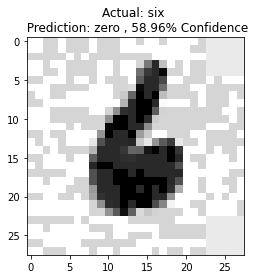

In [155]:
fgsm_adv = fgsm(image=img.reshape((1, img_rows, img_cols, channels)), 
                label=img_lbl, 
                eps=0.1)
fgsm_pred = mnist_model.predict(fgsm_adv)
plt.figure()
plt.imshow(fgsm_adv.reshape(img_rows, img_cols), cmap=plt.cm.binary)
plt.title('Actual: {} \n Prediction: {} , {:.2f}% Confidence'.format(labels[actual.argmax()],
                                                                     labels[fgsm_pred.argmax()],
                                                                     fgsm_pred.max()*100))
plt.show()

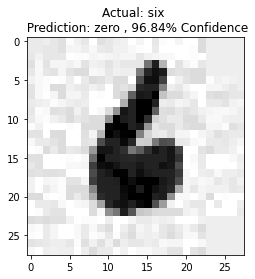

In [160]:
mi_fgsm_adv = mi_fgsm(image=img.reshape((1,img_rows, img_cols, channels)),
                      label=img_lbl,
                      decay_factor=0.1,
                      eps=0.08,
                      T=10)
mi_fgsm_pred = mnist_model.predict(mi_fgsm_adv)
plt.figure()
plt.imshow(mi_fgsm_adv.reshape(img_rows, img_cols), cmap=plt.cm.binary)
plt.title('Actual: {} \n Prediction: {} , {:.2f}% Confidence'.format(labels[actual.argmax()],
                                                                     labels[mi_fgsm_pred.argmax()],
                                                                     mi_fgsm_pred.max()*100))
plt.show()

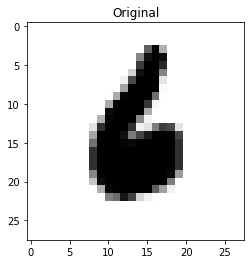

In [154]:
plt.figure()
plt.imshow(img.reshape(28,28), cmap=plt.cm.binary)
plt.title('Original')
plt.show()